# 🏠 House Price Prediction — Model Comparison

This notebook trains and compares multiple regression models on the Ames Housing dataset.



## 1) Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)


## 2) Imports

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt

xgb_available = True
try:
    from xgboost import XGBRegressor
except Exception:
    xgb_available = False

RANDOM_STATE = 42


In [3]:
# --- Load data robustly from root or data/ ---
import os
import pandas as pd

target_col = "SalePrice"

CANDIDATES = [
    "data/AmesHousing.csv",
    "data/train.csv",
    "AmesHousing.csv",
    "train.csv",
]

csv_path = next((p for p in CANDIDATES if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError(
        "Could not find dataset. Put AmesHousing.csv (or train.csv) in ./data/ "
        "or the notebook folder, then re-run."
    )

print(f"Using dataset: {csv_path}")
df = pd.read_csv(csv_path)

if target_col not in df.columns:
    raise ValueError(
        f"Expected '{target_col}' in the dataset. Columns include: {list(df.columns)[:15]} ..."
    )

df.head()


Using dataset: data/AmesHousing.csv


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 3) Load data

In [5]:
import os
import pandas as pd

DATA_PATH = "data/AmesHousing.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"❌ Dataset not found at {DATA_PATH}. Please place AmesHousing.csv inside the 'data/' folder."
    )

df = pd.read_csv(DATA_PATH)
print(f"📄 Using dataset: {DATA_PATH} — rows: {len(df)}")

target_col = 'SalePrice'
if target_col not in df.columns:
    raise ValueError(f"Expected '{target_col}' in the dataset. Columns include: {list(df.columns)[:12]} ...")

df.head()


📄 Using dataset: data/AmesHousing.csv — rows: 2930


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## 4) Basic cleaning & imputations

In [6]:
cols_to_drop = ['Pool QC','Misc Feature','Alley','Fence','Order','PID']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)

cat_fill_none = [
    'Mas Vnr Type','Fireplace Qu','Garage Type','Garage Finish','Garage Qual','Garage Cond',
    'Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2'
]
for col in cat_fill_none:
    if col in df.columns:
        df[col] = df[col].fillna('None')

for col in ['Lot Frontage','Mas Vnr Area','Garage Yr Blt']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

for col in ['Bsmt Half Bath','Bsmt Full Bath','BsmtFin SF 2','Garage Cars','Garage Area',
            'BsmtFin SF 1','Bsmt Unf SF','Total Bsmt SF']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

if 'Electrical' in df.columns:
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode().iloc[0])
df.isna().sum().sort_values(ascending=False).head(10)


MS SubClass      0
Half Bath        0
Fireplace Qu     0
Fireplaces       0
Functional       0
TotRms AbvGrd    0
Kitchen Qual     0
Kitchen AbvGr    0
Bedroom AbvGr    0
Full Bath        0
dtype: int64

## 5) Split & preprocessing pipeline

In [7]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(float)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

def rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error as _mse
    import numpy as _np
    return _np.sqrt(_mse(y_true, y_pred))


## 6) Define candidate models (including a baseline)

In [8]:
model_defs = {
    'Baseline (Mean)': DummyRegressor(strategy='mean'),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=10.0),
    'Lasso': Lasso(alpha=0.0005, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
}
if xgb_available:
    model_defs['XGBoost'] = XGBRegressor(
        n_estimators=1000, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, n_jobs=-1, random_state=RANDOM_STATE,
        objective='reg:squarederror'
    )

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
model_defs


{'Baseline (Mean)': DummyRegressor(),
 'Linear Regression': LinearRegression(),
 'Ridge': Ridge(alpha=10.0),
 'Lasso': Lasso(alpha=0.0005, max_iter=10000),
 'Random Forest': RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42),
 'Gradient Boosting': GradientBoostingRegressor(random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n

## 7) Train each model (with CV) and evaluate on test

In [9]:
results_rows = []
fitted_pipes = {}

for name, base_model in model_defs.items():
    ttr = TransformedTargetRegressor(
        regressor=base_model,
        func=np.log1p,
        inverse_func=np.expm1
    )
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', ttr)])

    cv = cross_validate(
        pipe, X_train, y_train,
        cv=kf,
        scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'),
        n_jobs=-1,
        return_train_score=False
    )
    cv_r2 = np.mean(cv['test_r2'])
    cv_rmse = -np.mean(cv['test_neg_root_mean_squared_error'])
    cv_mae = -np.mean(cv['test_neg_mean_absolute_error'])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = rmse(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)

    results_rows.append({
        'Model': name,
        'CV_R2': cv_r2,
        'CV_RMSE': cv_rmse,
        'CV_MAE': cv_mae,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae
    })
    fitted_pipes[name] = pipe

results = pd.DataFrame(results_rows).set_index('Model').sort_values('Test_RMSE')
print('\n=== Model performance (sorted by Test_RMSE) ===')
print(results.round(4))
results.round(4).to_csv('models/model_performance.csv', index=True)
results.round(4)



=== Model performance (sorted by Test_RMSE) ===
                    CV_R2     CV_RMSE      CV_MAE  Test_R2   Test_RMSE  \
Model                                                                    
XGBoost            0.8915  24760.9414  14156.0080   0.9286  23921.3339   
Random Forest      0.8734  27024.5693  16272.1510   0.9108  26744.7241   
Gradient Boosting  0.8824  25532.0830  15173.1254   0.9084  27104.9941   
Ridge              0.1982  47302.7379  16282.9630   0.8724  31989.5985   
Lasso              0.1656  47209.4908  15834.0474   0.8610  33378.6807   
Linear Regression  0.1739  47257.6705  16056.1524   0.8562  33960.1468   
Baseline (Mean)   -0.0334  78306.1339  54256.5039  -0.0777  92955.4976   

                     Test_MAE  
Model                          
XGBoost            14004.4520  
Random Forest      16101.6084  
Gradient Boosting  15442.6034  
Ridge              15591.9140  
Lasso              15131.5088  
Linear Regression  15011.6651  
Baseline (Mean)    63733.063

,CV_R2,CV_RMSE,CV_MAE,Test_R2,Test_RMSE,Test_MAE
Model,,,,,,
XGBoost,0.8915,24760.9414,14156.0080,0.9286,23921.3339,14004.4520
Random Forest,0.8734,27024.5693,16272.1510,0.9108,26744.7241,16101.6084
Gradient Boosting,0.8824,25532.0830,15173.1254,0.9084,27104.9941,15442.6034
Ridge,0.1982,47302.7379,16282.9630,0.8724,31989.5985,15591.9140
Lasso,0.1656,47209.4908,15834.0474,0.8610,33378.6807,15131.5088
Linear Regression,0.1739,47257.6705,16056.1524,0.8562,33960.1468,15011.6651
Baseline (Mean),-0.0334,78306.1339,54256.5039,-0.0777,92955.4976,63733.0634


## 8) Compare models — plots (saved to `figures/`)

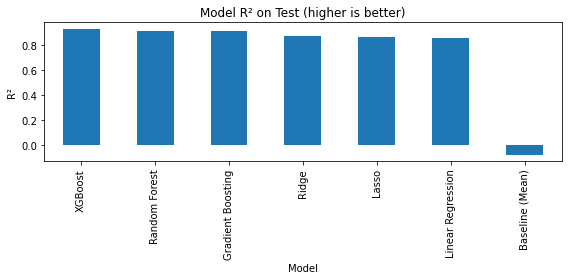

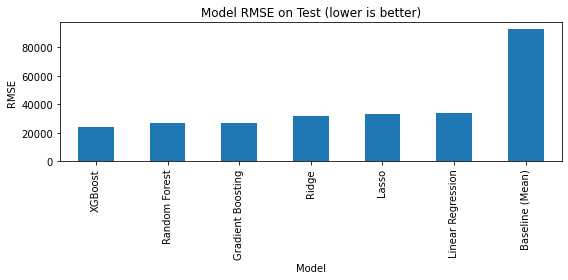

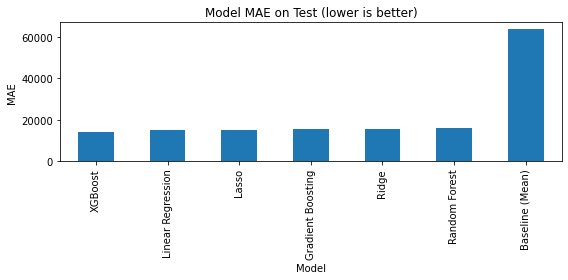

In [10]:
plt.figure(figsize=(8, 4))
results['Test_R2'].sort_values(ascending=False).plot(kind='bar')
plt.title('Model R² on Test (higher is better)')
plt.ylabel('R²'); plt.xlabel('Model'); plt.tight_layout()
plt.savefig('figures/test_r2.png', dpi=200)
plt.show()

plt.figure(figsize=(8, 4))
results['Test_RMSE'].sort_values(ascending=True).plot(kind='bar')
plt.title('Model RMSE on Test (lower is better)')
plt.ylabel('RMSE'); plt.xlabel('Model'); plt.tight_layout()
plt.savefig('figures/test_rmse.png', dpi=200)
plt.show()

plt.figure(figsize=(8, 4))
results['Test_MAE'].sort_values(ascending=True).plot(kind='bar')
plt.title('Model MAE on Test (lower is better)')
plt.ylabel('MAE'); plt.xlabel('Model'); plt.tight_layout()
plt.savefig('figures/test_mae.png', dpi=200)
plt.show()


## 9) Pick the best model and save the full pipeline

In [11]:
best_name = results.index[0]
print(f'Best model by Test RMSE: {best_name}')
best_pipe = fitted_pipes[best_name]

best_pipe.fit(X, y)

import joblib
model_path = os.path.join('models', 'house_price_model.pkl')
joblib.dump(best_pipe, model_path)
print(f'Saved best model to: {model_path}')


Best model by Test RMSE: XGBoost
Saved best model to: models\house_price_model.pkl


## 10) Diagnostics for the winning model (plots saved)

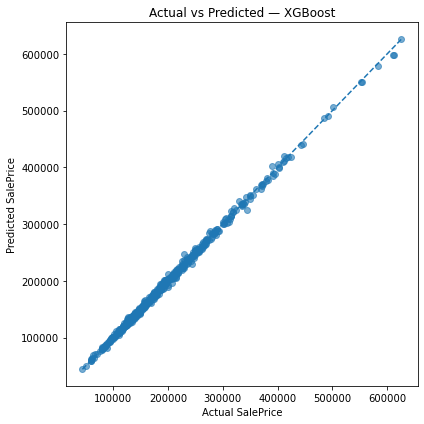

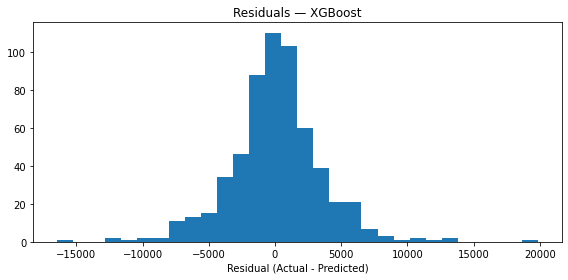

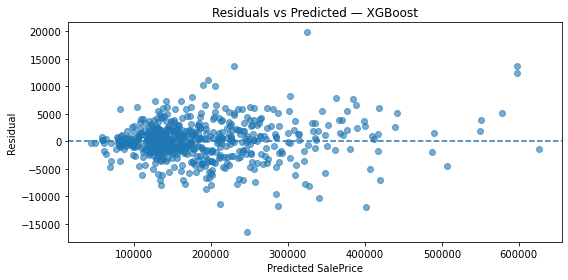

In [12]:
best_train_pipe = fitted_pipes[best_name]
y_pred_best = best_train_pipe.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
lo = min(y_test.min(), y_pred_best.min())
hi = max(y_test.max(), y_pred_best.max())
plt.plot([lo, hi], [lo, hi], linestyle='--')
plt.title(f'Actual vs Predicted — {best_name}')
plt.xlabel('Actual SalePrice'); plt.ylabel('Predicted SalePrice')
plt.tight_layout()
plt.savefig('figures/actual_vs_pred.png', dpi=200)
plt.show()

residuals = y_test - y_pred_best
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30)
plt.title(f'Residuals — {best_name}')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.savefig('figures/residuals_hist.png', dpi=200)
plt.show()

plt.figure(figsize=(8, 4))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.title(f'Residuals vs Predicted — {best_name}')
plt.xlabel('Predicted SalePrice'); plt.ylabel('Residual')
plt.tight_layout()
plt.savefig('figures/residuals_vs_pred.png', dpi=200)
plt.show()


In [13]:
# Sort results by Test RMSE
results_sorted = results.sort_values("Test_RMSE")

# Display best model
best_model = results_sorted.index[0]
print(f"✅ Best Model: {best_model}")

# Export full results as markdown for README
print("\n### 📊 Model Performance Comparison\n")
print(results_sorted.to_markdown())


✅ Best Model: XGBoost

### 📊 Model Performance Comparison

| Model             |      CV_R2 |   CV_RMSE |   CV_MAE |    Test_R2 |   Test_RMSE |   Test_MAE |
|:------------------|-----------:|----------:|---------:|-----------:|------------:|-----------:|
| XGBoost           |  0.891486  |   24760.9 |  14156   |  0.928628  |     23921.3 |    14004.5 |
| Random Forest     |  0.873383  |   27024.6 |  16272.2 |  0.910786  |     26744.7 |    16101.6 |
| Gradient Boosting |  0.882427  |   25532.1 |  15173.1 |  0.908366  |     27105   |    15442.6 |
| Ridge             |  0.198184  |   47302.7 |  16283   |  0.872363  |     31989.6 |    15591.9 |
| Lasso             |  0.1656    |   47209.5 |  15834   |  0.861038  |     33378.7 |    15131.5 |
| Linear Regression |  0.173885  |   47257.7 |  16056.2 |  0.856154  |     33960.1 |    15011.7 |
| Baseline (Mean)   | -0.0334087 |   78306.1 |  54256.5 | -0.0777266 |     92955.5 |    63733.1 |
